In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
from tqdm.notebook import tqdm
import numpy as np
import re
import random
from datetime import datetime
import matplotlib.pyplot as plt

torch.manual_seed(1)
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
# read in vocab and embeddings from GloVe
glove_path = 'glove.6B.300d.txt'

embedding_dim = 300
glove_vocab_size = 400000

glove_vocab = []
glove_vectors = torch.empty((glove_vocab_size, embedding_dim), dtype=torch.float)

with open(glove_path, 'r', encoding='UTF-8') as f:
    for i, line in enumerate(tqdm(f.readlines())):
        parsed_line = line.split()
        glove_vocab += [parsed_line[0]]
        glove_vectors[i,:] = torch.reshape(torch.tensor(list(map(float, parsed_line[1:])), dtype=torch.float), (1,embedding_dim))

  0%|          | 0/400000 [00:00<?, ?it/s]

In [23]:
glove_idx = torch.LongTensor(torch.zeros(glove_vocab_size,dtype=int))
for idx in range(glove_vocab_size):
    glove_idx[idx] = idx + 1

In [24]:
vocab = ['<pad>'] + glove_vocab
padding_index = 0

vocab_dict = {}
for idx in range(len(vocab)):
    vocab_dict[vocab[idx]] = idx
    
# read in train filepath
train_dir = 'review_polarity/txt_sentoken/train'
train_data_unshuffled = []

pos_dir = train_dir + '/pos'
for filename in tqdm(os.listdir(pos_dir)):
    if filename.endswith(".txt"):
        filepath = pos_dir + '/' + filename
        train_data_unshuffled += [(filepath, 1)]

neg_dir = train_dir + '/neg'
for filename in tqdm(os.listdir(neg_dir)):
    if filename.endswith(".txt"):
        filepath = neg_dir + '/' + filename
        train_data_unshuffled += [(filepath, 0)]
        
train_data = random.sample(train_data_unshuffled, len(train_data_unshuffled))
train_size = len(train_data)

train_vocab = []
for filename, _ in tqdm(train_data):
    with open(filename, 'r', encoding='UTF-8') as f:
        for line in f.readlines():
            parsed_line = line.split()
            for token in parsed_line:
                if vocab_dict.get(token) == None:
                    token_split = re.split('([^a-zA-Z0-9])', token)
                    for sub_token in token_split:
                        if vocab_dict.get(sub_token) == None:
                            if sub_token != '':
                                vocab_dict[sub_token] = len(vocab_dict)
                                vocab += [sub_token]
                                train_vocab += [sub_token]

vocab_size = len(vocab)

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/695 [00:00<?, ?it/s]

  0%|          | 0/1400 [00:00<?, ?it/s]

In [25]:
# read in train dataset
train_dir = 'review_polarity/txt_sentoken/train'

train_file_to_idx = {}
train_idx_to_file = np.empty(train_size, dtype=np.dtype('U100'))
train_idx_to_label = np.empty(train_size, dtype=int)

train_idx_to_vector = {}
train_idx_to_length = np.empty(train_size, dtype=int)

for idx, (filename, label) in tqdm(enumerate(train_data)):
    train_file_to_idx[filename] = idx
    train_idx_to_file[idx] = filename
    train_idx_to_label[idx] = label
    
    vector = []
    with open(filename, 'r', encoding='UTF-8') as f:
        for line in f.readlines():
            parsed_line = line.split()
            for token in parsed_line:
                if vocab_dict.get(token) != None:
                    vector += [vocab_dict[token]]
                else:
                    token_split = re.split('([^a-zA-Z0-9])', token)
                    for sub_token in token_split:
                        if vocab_dict.get(sub_token) != None and sub_token != '':
                            vector += [vocab_dict[sub_token]]
    train_idx_to_vector[idx] = vector
    train_idx_to_length[idx] = len(vector)
    
train_idx = list(range(train_size))

0it [00:00, ?it/s]

In [26]:
# read in dev filepath
dev_dir = 'review_polarity/txt_sentoken/dev'
dev_data_unshuffled = []

pos_dir = dev_dir + '/pos'
for filename in tqdm(os.listdir(pos_dir)):
    if filename.endswith(".txt"):
        filepath = pos_dir + '/' + filename
        dev_data_unshuffled += [(filepath, 1)]

neg_dir = dev_dir + '/neg'
for filename in tqdm(os.listdir(neg_dir)):
    if filename.endswith(".txt"):
        filepath = neg_dir + '/' + filename
        dev_data_unshuffled += [(filepath, 0)]
        
dev_data = random.sample(dev_data_unshuffled, len(dev_data_unshuffled))
dev_size = len(dev_data)

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

In [27]:
# read in dev dataset
dev_dir = 'review_polarity/txt_sentoken/dev'

dev_file_to_idx = {}
dev_idx_to_file = np.empty(dev_size, dtype=np.dtype('U100'))
dev_idx_to_label = np.empty(dev_size, dtype=int)

dev_idx_to_vector = {}
dev_idx_to_length = np.empty(train_size, dtype=int)

for idx, (filename, label) in tqdm(enumerate(dev_data)):
    dev_file_to_idx[filename] = idx
    dev_idx_to_file[idx] = filename
    dev_idx_to_label[idx] = label
    
    vector = []
    with open(filename, 'r', encoding='UTF-8') as f:
        for line in f.readlines():
            parsed_line = line.split()
            for token in parsed_line:
                if vocab_dict.get(token) != None:
                    vector += [vocab_dict[token]]
                else:
                    token_split = re.split('([^a-zA-Z0-9])', token)
                    for sub_token in token_split:
                        if vocab_dict.get(sub_token) != None and sub_token != '':
                            vector += [vocab_dict[sub_token]]
    dev_idx_to_vector[idx] = vector
    dev_idx_to_length[idx] = len(vector)
    
dev_idx = list(range(dev_size))

0it [00:00, ?it/s]

In [28]:
# read in test filepath
test_dir = 'review_polarity/txt_sentoken/test'
test_data_unshuffled = []

pos_dir = test_dir + '/pos'
for filename in tqdm(os.listdir(pos_dir)):
    if filename.endswith(".txt"):
        filepath = pos_dir + '/' + filename
        test_data_unshuffled += [(filepath, 1)]

neg_dir = test_dir + '/neg'
for filename in tqdm(os.listdir(neg_dir)):
    if filename.endswith(".txt"):
        filepath = neg_dir + '/' + filename
        test_data_unshuffled += [(filepath, 0)]
        
test_data = random.sample(test_data_unshuffled, len(test_data_unshuffled))
test_size = len(test_data)

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

In [29]:
# read in test dataset
test_dir = 'review_polarity/txt_sentoken/test'

test_file_to_idx = {}
test_idx_to_file = np.empty(test_size, dtype=np.dtype('U100'))
test_idx_to_label = np.empty(test_size, dtype=int)

test_idx_to_vector = {}
test_idx_to_length = np.empty(train_size, dtype=int)

for idx, (filename, label) in tqdm(enumerate(test_data)):
    test_file_to_idx[filename] = idx
    test_idx_to_file[idx] = filename
    test_idx_to_label[idx] = label
    
    vector = []
    with open(filename, 'r', encoding='UTF-8') as f:
        for line in f.readlines():
            parsed_line = line.split()
            for token in parsed_line:
                if vocab_dict.get(token) != None:
                    vector += [vocab_dict[token]]
                else:
                    token_split = re.split('([^a-zA-Z0-9])', token)
                    for sub_token in token_split:
                        if vocab_dict.get(sub_token) != None and sub_token != '':
                            vector += [vocab_dict[sub_token]]
    test_idx_to_vector[idx] = vector
    test_idx_to_length[idx] = len(vector)
    
test_idx = list(range(test_size))

0it [00:00, ?it/s]

In [30]:
# functions
def batch_to_padded_tensors(batch, mode):
    if mode == 'train':
        idx_to_vector = train_idx_to_vector
        idx_to_length = train_idx_to_length
    elif mode == 'dev':
        idx_to_vector = dev_idx_to_vector
        idx_to_length = dev_idx_to_length
    elif mode == 'test':
        idx_to_vector = test_idx_to_vector
        idx_to_length = test_idx_to_length
    
    size = len(batch)
    lengths = idx_to_length[batch]
    max_length = max(lengths)
    
    tensors = torch.zeros((size, max_length), dtype=int).long()
    for i, idx in enumerate(batch):
        tensors[i, 0:idx_to_length[idx]] = torch.LongTensor(idx_to_vector[idx.item()])
               
    return tensors.to(device)

def batch_to_labels(batch, mode):
    if mode == 'train':
        idx_to_label = train_idx_to_label
    elif mode == 'dev':
        idx_to_label = dev_idx_to_label
    elif mode == 'test':
        idx_to_label = test_idx_to_label
        
    return torch.LongTensor(idx_to_label[batch]).to(device)

In [64]:
#hyper-parameters
hidden_size = 128
num_labels = 2

num_epochs = 200
learning_rate = 0.001

batch_size = 10

train_loader = torch.utils.data.DataLoader(train_idx, batch_size=batch_size)
dev_loader = torch.utils.data.DataLoader(dev_idx, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_idx, batch_size=batch_size)

In [57]:
class RNN_Classifier(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
    
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_index)
        
        # initialize embeddings with glove embeddings
        with torch.no_grad():
            self.embedding.weight[glove_idx] = glove_vectors
        
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.hidden_to_label = nn.Linear(hidden_size, num_labels)
                
    def forward(self, document_tensors):
        """
        document_tensors : batch_size x sequence_length
        """
        batch_size, sequence_length = document_tensors.shape
        hidden_0 = torch.zeros((1, batch_size, self.hidden_size),dtype=torch.float).to(device)
        
        document_embeddings = self.embedding(document_tensors)
        rnn_out, _ = self.rnn(document_embeddings.view(batch_size, sequence_length, embedding_dim), hidden_0)
        pooling_out = self.pooling(rnn_out.transpose(1,2)).transpose(1,2)
        
        score = self.hidden_to_label(pooling_out).view(batch_size, -1)
        
        return F.log_softmax(score, dim=1)

In [81]:
def evaluate(model, data_loader, mode):
    true_pos_count = 0
    false_pos_count = 0
    true_neg_count = 0
    false_neg_count = 0

    with torch.no_grad():
        for index, batch in enumerate(data_loader):
            current_batch_size = len(batch)
            
            batch_tensors = batch_to_padded_tensors(batch, mode)
            batch_labels = batch_to_labels(batch, mode)

            log_probs = model(batch_tensors)

            predicted_labels = torch.argmax(log_probs, 1)

            for i in range(current_batch_size):
                if batch_labels[i] == 1 and predicted_labels[i] == 1:
                    true_pos_count += 1
                elif batch_labels[i] == 0 and predicted_labels[i] == 1:
                    false_pos_count += 1
                elif batch_labels[i] == 0 and predicted_labels[i] == 0:
                    true_neg_count += 1
                elif batch_labels[i] == 1 and predicted_labels[i] == 0:
                    false_neg_count += 1

    accuracy = (true_pos_count + true_neg_count) / (true_pos_count + false_pos_count + true_neg_count + false_neg_count)
    
    # compute F1 score on the class of pos reviews
    if true_pos_count + false_pos_count != 0:
        precision_pos = true_pos_count / (true_pos_count + false_pos_count)
    else: 
        precision_pos = 0
    if true_pos_count + false_neg_count != 0:
        recall_pos = true_pos_count / (true_pos_count + false_neg_count)
    else: 
        recall_pos = 0
    
    if precision_pos + recall_pos != 0:
        F1_pos = 2 * (precision_pos * recall_pos) / (precision_pos + recall_pos)
    else:
        F1_pos = 0
    
    # compute F1 score on the class of neg reviews
    if true_neg_count + false_neg_count != 0:
        precision_neg = true_neg_count / (true_neg_count + false_neg_count)
    else: 
        precision_neg = 0
    if true_neg_count + false_neg_count != 0:
        recall_neg = true_neg_count / (true_neg_count + false_pos_count)
    else: 
        recall_neg = 0
    
    if precision_neg + recall_neg != 0:
        F1_neg = 2 * (precision_neg * recall_neg) / (precision_neg + recall_neg)
    else:
        F1_neg = 0
        
    F1 = (F1_pos + F1_neg) / 2

    return accuracy, F1

In [71]:
epoch_train_accuracy = [0] * num_epochs
epoch_train_F1 = [0] * num_epochs
    
epoch_dev_accuracy = [0] * num_epochs
epoch_dev_F1 = [0] * num_epochs

def train(model, train_loader):
    start_time = datetime.now()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        print('epoch', epoch)
        for index, batch in enumerate(tqdm(train_loader)):
            current_batch_size = len(batch)
            batch_tensors = batch_to_padded_tensors(batch, 'train')
            batch_labels = batch_to_labels(batch, 'train')
            
            log_probs = model(batch_tensors)
            model.zero_grad()
            
            loss = F.nll_loss(log_probs, batch_labels)
            loss.backward()
               
            model.embedding.weight.grad[glove_idx] = 0
            
            optimizer.step()
        
        epoch_train_accuracy[epoch], epoch_train_F1[epoch] = evaluate(model, train_loader, 'train')
        print('train accuracy = {val1:0.5f}'.format(val1=epoch_train_accuracy[epoch]), 'train macro-F1 = {val2:0.5f}'.format(val2=epoch_train_F1[epoch]))
        
        epoch_dev_accuracy[epoch], epoch_dev_F1[epoch] = evaluate(model, dev_loader, 'dev')
        print('dev accuracy = {val1:0.5f}'.format(val1=epoch_dev_accuracy[epoch]), 'dev macro-F1 = {val2:0.5f}'.format(val2=epoch_dev_F1[epoch]))
        
    end_time = datetime.now()
    total_time = end_time-start_time
    
    print('total training time:', total_time)

In [60]:
model = RNN_Classifier(hidden_size).to(device)

In [72]:
train(model, train_loader)

epoch 0


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.87857 train macro-F1 = 0.87779
dev accuracy = 0.88667 dev macro-F1 = 0.88649
epoch 1


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.91429 train macro-F1 = 0.91405
dev accuracy = 0.92333 dev macro-F1 = 0.92333
epoch 2


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.95643 train macro-F1 = 0.95640
dev accuracy = 0.95667 dev macro-F1 = 0.95666
epoch 3


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.97786 train macro-F1 = 0.97785
dev accuracy = 0.98667 dev macro-F1 = 0.98666
epoch 4


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.98571 train macro-F1 = 0.98571
dev accuracy = 0.99000 dev macro-F1 = 0.98999
epoch 5


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99000 train macro-F1 = 0.99000
dev accuracy = 0.99000 dev macro-F1 = 0.98999
epoch 6


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99786 train macro-F1 = 0.99786
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 7


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99786 train macro-F1 = 0.99786
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 8


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99857 train macro-F1 = 0.99857
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 9


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 10


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 11


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 12


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 13


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 14


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 15


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 16


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 17


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 18


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 19


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 0.99929 train macro-F1 = 0.99929
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 20


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 21


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 22


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 23


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 24


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 25


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 26


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 27


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 28


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 29


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 30


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 31


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 32


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 33


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 34


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 35


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 36


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 37


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 38


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 39


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 40


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 41


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 42


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 43


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 44


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 45


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 46


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 47


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 48


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
epoch 49


  0%|          | 0/140 [00:00<?, ?it/s]

train accuracy = 1.00000 train macro-F1 = 1.00000
dev accuracy = 1.00000 dev macro-F1 = 1.00000
total training time: 0:05:53.888752


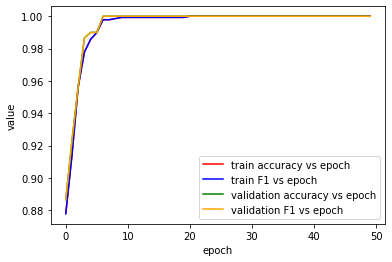

In [73]:
plt.plot(range(num_epochs), epoch_train_accuracy, label='train accuracy vs epoch', color='red' )
plt.plot(range(num_epochs), epoch_train_F1, label='train F1 vs epoch', color='blue' )
plt.plot(range(num_epochs), epoch_dev_accuracy, label='validation accuracy vs epoch', color='green' )
plt.plot(range(num_epochs), epoch_dev_F1, label='validation F1 vs epoch', color='orange' )
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()

In [82]:
test_accuracy, test_F1 = evaluate(model, test_loader, 'test')
print('test accuracy = {val1:0.5f}'.format(val1=test_accuracy), 'test macro-F1 = {val2:0.5f}'.format(val2=test_F1))

test accuracy = 1.00000 test macro-F1 = 1.00000
